# Analyse the embeddings

### 1.1 import

In [2]:
import warnings

from matplotlib.pyplot import subplots

%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import json
from CAT import utils
from CAT import model
from CAT import dataset
import torch
import pandas as pd

import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2. logger set up

In [3]:
utils.setuplogger(verbose = True, log_name="Embedding_explore")

In [4]:
utils.set_seed(0)

### 1.3. Metric computing

In [5]:
dataset_name = 'postcovid'
algo_name = 'Bivaecf_cornac'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_Iter_fold{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/postcovid_Bivaecf_cornac_Iter_fold0_seed_0.csv'

In [6]:
dataset_name = 'portrait'
layer_n = 2
algo_name = f'DotProduct_{layer_n}_without_init_cont_model'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/portrait_DotProduct_2_without_init_cont_model_fold_0_seed_0.csv'

#### 1.3.3. DOA

In [ ]:
reload(utils)
utils.compute_doa(embs, dataset_name, algo_name)

#### 1.3.2. Correlation coeff

In [ ]:
reload(utils)
utils.compute_corr_coeff(embs=embs, dataset_name=dataset_name,fold_nb=5)

#### 1.3.1. RM

In [ ]:
reload(utils)
utils.compute_rm(embs=embs, dataset_name=dataset_name)

### 1.4. Qualitative study
#### 1.4.1. Imports

In [7]:
# choose dataset here
dataset_name = 'postcovid'
version= ""#"_small"
# modify config here

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

config = {

    # General params
    'seed' : 0,

    # Saving params
    'load_params': False,
    'save_params': False,
    'embs_path' : '../embs/'+str(dataset_name),
    'params_path' :'../ckpt/'+str(dataset_name),

    # training mode
    'early_stopping' : True,
    'fast_training' : True, # (Only taken in account if early_stopping == true) If true, doesn't compute valid rmse PC-ER

    # Learning params
    'learning_rate': 0.001,
    'batch_size': 2048,
    'num_epochs': 200,
    'num_dim': 10, # for IRT or MIRT todo : is it necessary as we use concepts knowledge number as embedding dimension ?
    'eval_freq' : 1,
    'patience' : 30,
    'device': device,
    'lambda' : 7.7e-6,
    'tensorboard': False,
    'flush_freq' : True,

    # for NeuralCD
    'prednet_len1': 128,
    'prednet_len2': 64,
    'best_params_path':'',

    #For GCCD
    'num_layers': 0,
    'version': 'pair',
    'p_dropout': 0,
    'low_mem_mode' : True,
    'user_nbrs_n' : 10,
    'item_nbrs_n' : 5
}
concept_map = json.load(open(f'../datasets/{dataset_name}/concept_map.json', 'r'))
concept_map = {int(k):[int(x) for x in v] for k,v in concept_map.items()}
metadata = json.load(open(f'../datasets/{dataset_name}/metadata.json', 'r'))
utils.set_seed(config['seed'])
dataset_name += version
logging.info(f'#### {dataset_name} ####')
logging.info(f'#### config : {config} ####')

[INFO 04:52] #### postcovid ####


In [ ]:
reload(utils)
reload(model)
reload(dataset)
import torch

config['early_stopping'] = False
config['save_params']=False # Save all model parameters and save an array of the embeddings
config['num_epochs']= 200
config['learning_rate'] = 0.126
config['lambda'] = 7.7e-6
config['d_in'] = 3
config['num_responses'] = 11
config['verbose_early_stopping'] = False
config['esc'] = 'delta_error' #'loss' 'delta_objectives'

config['load_params'] = True

for seed in range(1):

    # Set the seed
    utils.set_seed(seed)
    config['seed'] = seed
    metrics = {"mae":[],"rmse":[], "pc-er" : []}
    embs = []
    preds = []

    algo = model.DBPR(**config)


    for i_fold in range(1):

        # read datasets
        train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{i_fold}.csv',
                                     encoding='utf-8').to_records(index=False,
                                                                  column_dtypes={'student_id': int, 'item_id': int,
                                                                                 "correct": float,"dimension_id":int})

        test_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_test_quadruples_vert_{i_fold}.csv',
                                    encoding='utf-8').to_records(index=False,
                                                                 column_dtypes={'student_id': int, 'item_id': int,
                                                                                 "correct": float,"dimension_id":int})

        train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)

        test_data = dataset.LoaderDataset(test_quadruplets, concept_map, metadata)

        # Init model
        algo.init_model(train_data, None)

        # test model ----
        metrics["pc-er"].append(algo.evaluate_emb(test_data,concept_map)['pc-er'])
        eval = algo.evaluate_test(test_data)
        metrics["rmse"].append(eval["rmse"])
        metrics["mae"].append(eval["mae"])
        preds.append(eval['preds'])
        embs.append(algo.get_user_emb())
        df = pd.DataFrame(metrics)

        # save model
        df['rmse'] = df['rmse'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
        df['mae'] = df['mae'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
        df['pc-er'] = df['pc-er'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

        logging.info('rmse : {:.4f} +- {:.4f}'.format(df['rmse'].mean(), df['rmse'].std()))
        logging.info('mae : {:.4f} +- {:.4f}'.format(df['mae'].mean(), df['mae'].std()))
        logging.info('pc-er : {:.4f} +- {:.4f}'.format(df['pc-er'].mean(), df['pc-er'].std()))

In [ ]:
num_responses = 11
R_t = train_data.log_tensor.T - 1
mask = torch.zeros(R_t.shape).bool()
for item_i, logs in enumerate(R_t) :
    T = (torch.unique(logs)*(num_responses-1)).int()
    mask[item_i,T[T!=-11]] = True

In [ ]:
mask

In [ ]:
1*11

In [ ]:
Y = [0.4900, 0.4900, 0.3600, 0.3600, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600,
        0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600,
        0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600,
        0.1600, 0.1600, 0.1600, 0.1600, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400]
plt.plot(np.arange(len(Y)),Y)
plt.xlabel("Log")
plt.ylabel("Squared error")
plt.title("Distribution of the worst squared error prediction on the test dataset")

In [ ]:
import matplotlib.pyplot as plt
Y =  [1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.1, 1.6, 1.6, 1.1, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.6, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.6, 1.6, 1.1, 1.4, 1.4, 1.1, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.6, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.1, 1.6, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.1, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.1, 1.4, 1.4, 1.4, 1.1, 1.6, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.1, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.6, 1.1, 1.4, 1.1, 1.1, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.6, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.4, 1.4, 1.4, 1.1, 1.4, 1.1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
plt.hist(Y)
plt.xlabel('response scale')
plt.ylabel('Number of responses')
plt.title('Labels of the 1000 best predicted values')


In [ ]:
Y = [2.0, 1.2, 1.1, 1.1, 1.8, 1.2, 1.1, 1.1, 1.1, 1.0, 1.4, 1.7, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.4, 1.4, 1.4, 1.4, 1.7, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.3, 1.2, 1.3, 1.2, 1.2, 1.3, 1.7, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.7, 1.3, 1.3, 1.2, 1.3, 1.2, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, 1.7, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.3, 1.3, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.7, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.4, 1.4, 1.1, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.1, 1.4, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]

plt.hist(Y)
plt.xlabel('response scale')
plt.ylabel('Number of responses')
plt.title('Labels of the 1000 worst predicted values')

In [ ]:
# Best results
scores = []
items = []
users = []
concepts = []

for l in[8500, 7888, 6473, 9338, 2349, 6260, 3282, 6355, 6358, 7886, 1434, 4580,
        8502, 7479, 2930, 6246, 2931, 2192,  399, 3565,  242, 6471, 5583, 7173,
        4094, 4096, 5129, 2191, 9953, 1081, 5314, 7256, 5098,  221, 7268, 7266,
        2160, 4698, 9426, 7924, 5912, 7267, 6909, 9225, 9679, 3899, 9220, 3682,
        5214, 3157, 7313, 2170, 2717, 3522, 2261, 8514, 8515, 7775, 7774, 9093,
        9784, 1039, 9437, 1412, 1900, 1032, 4848, 2062, 9749,  743, 9483, 6782,
        9838, 9620, 6789, 6790, 6466, 6784, 6531, 6777, 8692, 2905, 6537, 8125,
        2670, 5197, 4285, 2512, 9788, 6787, 6788, 9227, 9524, 4065, 6540, 9786,
        9243, 9164, 1160,  329, 6786, 6785, 9973, 1557, 2895, 9165,  701, 6967,
        2893,  265, 5596, 8796, 9974,  391, 3281, 9154, 3567, 2887, 5651, 8100,
        7100, 1130, 2671, 9621, 6459, 7840, 7841, 5198, 1036, 8099, 4319, 4326,
         379, 8854,  380, 9832, 9813, 3354, 2322, 8217, 5716,  527,  526, 1282,
        8264, 8265, 1343, 9814, 4837, 4487, 2437, 5717, 2438,  957, 2430, 9633,
        8662, 9317, 5224, 7419, 6488, 7973, 3703, 7334, 4998, 5261,  547, 7369,
        8649, 7705,    7, 7697, 3128, 4155, 7024, 7693, 8240, 2320, 1786, 4154,
        9753, 1005,  582, 8625, 2121, 2124, 9470, 7683, 5718, 7723, 7395,  535,
        8257,   44, 4841, 7934, 6057, 8022, 9429, 3150, 7223,  908, 8570, 9156,
         104, 6007, 9428, 1001, 5279, 9764,  890, 3694, 5223, 2150, 1003, 9553,
        3156, 3486, 9077, 7803, 9834, 5998, 3118, 6030, 6027, 9075, 6002, 3771,
        6457, 6455, 3818, 6986, 5396, 5395, 7765, 6262, 7807, 1284, 1230, 7805,
        3746, 3775, 7711, 1296, 7759, 7758, 3774, 7817, 7757, 3824, 1294, 3776,
        1299, 3735, 1301, 1302, 7025,  352, 1169, 3738, 1244, 3777, 1164, 5969,
        7761, 7816, 1292, 7754, 9085, 1168, 3126, 3740, 6001, 6031, 6448, 3758,
        7736, 9274, 1254, 6020, 1202, 8936, 4790, 9080, 1200, 3108, 7734, 6261,
        7733, 5987, 2327, 3122, 7743, 2342, 3793, 1214, 3119, 2332, 1213, 6257,
        1212, 7793, 3766, 2343, 6450, 6017, 3798, 3799, 7015, 3747, 3811, 1226,
        1277, 3748, 9831, 3812, 9084, 7004, 2336, 1185, 1184, 1183, 8822, 9076,
        1305, 3117, 3751, 3123, 3768, 1251, 3124, 9081, 6453, 7001, 1273, 7769,
        7336, 2354, 3749, 7796, 7797, 5394, 3116, 3917, 2081, 2423, 7956,  985,
        7185, 7962, 5905, 7963, 7964, 3913, 3914, 9401, 5901, 2082, 8763,  972,
        7312,  970, 5156, 3922, 8889, 3056, 6492,  960, 5890, 5406,  956, 6481,
        3887, 5404, 2409, 2410, 3072, 1018, 4953, 8776, 3896, 3897, 3071, 3070,
        2414,  955, 7929, 9872, 1004, 1002,  999,  998, 7935, 2417, 6267, 6951,
         993,  992,  990, 4273, 5631, 5632, 9346, 5633,  354, 9305,  369, 5092,
        6793, 2060,  364, 6792, 9153, 9121, 2912, 5025, 9349, 4282, 8404, 9962,
        8403, 8402, 8401, 8400, 4280, 9619, 2455, 8416, 2433, 6270, 3053, 6928,
        9876, 9963, 8428, 6774, 8426, 8691, 2666, 2906, 8418, 3886, 9209, 2907,
        9728, 9580,  319,  320, 2059, 4297, 5623,  327, 8410, 4561, 6600, 8791,
        7842, 2372, 8938, 5958, 1872, 1118, 5397, 3845, 4786, 7849, 1113, 7852,
        3381, 1124, 7864, 1104, 9544, 1102, 2381, 7865, 6962, 5952, 4949, 2383,
        3856, 7869, 2384, 1142, 6464, 5168, 6465, 1154, 2364, 1151, 8804, 3096,
        6264, 5167, 1145, 1144, 1143, 1092, 1140, 1139, 1138, 1137, 5964, 2369,
        3260, 1133, 5961, 5163, 8937, 7837, 1125, 6957, 7895, 3079, 5934, 3078,
        1054, 1053, 9548, 5931, 1050, 1049, 7899, 2399, 1046, 1059, 1043, 1042,
        2401, 4784, 1038, 3379, 3075, 9868, 3074, 6954, 7917, 7919, 2407, 9856,
        3262, 7873, 2387, 7874, 4950, 7878, 9186, 9410, 1082, 3863, 2389, 7884,
        3083, 3826, 1075, 9545, 7889, 6476, 1068, 1067, 1066, 2394, 1064, 1063,
        7893, 7894, 2395, 2169, 9056, 6181, 2162, 4888, 4683, 1644, 3226, 4826,
        4889, 9773, 4825, 4824, 2168, 4827, 1634, 6173, 4684, 2172, 1630, 2173,
        1628, 9700, 9774, 3523, 6165, 4822, 7451, 7445, 4828, 6192, 7446, 4883,
        5382, 1813, 2158, 9767, 3500, 3501, 9769, 3502, 6163, 1663, 7453, 7454,
        7455, 1659, 1658, 1657, 7456, 2159, 7459, 7460, 5212, 1573, 6373, 5267,
        6145, 3559, 2193, 6374, 7357, 3564, 1580, 9783, 1576, 1575, 7504, 1819,
        7506, 1569, 1824, 5268, 1825, 1565, 1826, 1827, 6380, 1561, 1560, 9448,
        3249, 3527, 3528, 3529, 3530, 3531, 4821, 3533, 3534, 6162, 3536, 3411,
        3538, 3539, 8863, 2179, 7486, 6157, 3543, 9512, 2181, 9697, 2183, 3548,
        1816, 1817, 1818, 7366, 7161, 7393, 9754, 7394, 1762, 1761, 3446, 7397,
        2105, 3239, 9755, 1754, 1753, 1806, 7400, 1750, 7401, 7403, 3237, 7404,
        7405, 1744, 1743, 7406, 7407, 1740, 2116, 7370, 2108, 2109, 2110, 2111,
        2112, 7171, 9188, 3426, 3427, 1802, 8882, 7168, 3236, 7381, 6233, 8881,
        2118, 7166, 1779, 4872, 6224, 7164, 6239, 2125, 9468, 5366, 7151, 3474,
        6200, 3414, 7148, 9048, 2148, 6198, 1700, 4829, 6197, 3484, 6196, 2144,
        9462, 2152, 7142, 3230, 3493, 7439, 7441, 1685, 1684, 1683, 9181, 5217,
        2137, 7408, 7409, 1736, 3453, 7364, 7410, 3455, 7412, 3234, 9045, 1728,
        3458, 2136, 1558, 2138, 3233, 7152, 7421, 4877, 2141, 4664, 6211, 2142,
        4662, 3470, 2143, 7057, 3163, 3673, 2096, 8836, 3161, 6420, 2273, 4804,
        1398, 6421, 2281, 9260, 9434, 7610, 9747, 9676, 9017, 9161, 9534, 4641,
        9535, 1377, 3149, 8834, 4919, 7639, 6413, 4912, 5188, 9796, 7348, 6410,
        6081, 9683, 6080, 9682, 1428, 1426, 3659, 5275, 1370, 1421, 1420, 7347,
        6077, 7599, 6414, 4644, 2265, 3402, 6416, 8837, 3164, 7689, 7337, 3135,
        1335, 3134, 6435, 1332, 1331, 3132, 6045, 2092, 9671, 9670, 7687, 7338,
        3728, 7690, 3729, 6441, 6039, 7694, 7698, 6445, 7699, 7702, 7703, 1307,
        8886, 1369, 1368, 7642, 7051, 1365, 4921, 7647, 9805, 3705, 4799, 3146,
        9073, 7660, 3173, 7662, 6432, 6254, 1349, 7664, 6433, 1345, 6434, 8887,
        3138, 1340, 7041, 1831, 3597, 3598, 6120, 6117, 6115, 9520, 6114, 1518,
        6112, 6111, 7532, 6110, 1830, 3596, 3609, 1832, 7535, 7541, 7542, 3611,
        1833, 7175, 6102, 9523, 3190, 2224, 3201, 9025, 4816, 9446, 6133, 3579,
        6382, 5269, 9516, 6131, 2099, 1545, 1544, 7515, 7550, 1541, 5201, 7103,
        6130, 9517, 8852, 1533, 3590, 6126, 6124, 9063, 6385, 2243, 7083, 8926,
        2235, 9024, 5385, 4808, 2238, 6397, 1838, 6402, 6403, 1454, 9440, 5270,
        2244, 1839, 1840, 1841, 9021, 2249, 6408, 3174, 2252, 6082, 2253, 5190,
        9791, 7551, 3619, 1491, 1490, 1489, 1487, 1486, 9790, 8885, 7554, 1482,
        1481, 1480, 1306, 1837, 1477, 1476, 1475, 8850, 1473, 2229, 7564, 4812,
        8847, 8846, 3185, 8429] :
    scores.append(test_data[l][3])
    items.append(test_data[l][1])
    concepts.append(test_data[l][2])
    users.append(test_data[l][0])

best_pred=[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.600000023841858, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.600000023841858, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.600000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'C' is your data array
# Create the histogram and get the counts, bins, and patches
counts, bins, patches = plt.hist(np.array(concepts).T, bins=18, range=(0, 18))

# Set the x-axis ticks to label each bin from 0 to 18
plt.xticks(range(19))  # Ticks at every integer from 0 to 18

# Add the counts on top of each bar
for count, patch in zip(counts, patches):
    # Calculate the position for the text
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    # Add the text annotation
    plt.text(x, y, int(count), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Dimensions')
plt.ylabel('Number of responses')
plt.title('Distribution of the 300 best predictions over dimensions')

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
C = np.array(concepts)
# Assuming 'C' is your data array
# Create the histogram and get the counts, bins, and patches

# Assuming 'algo.model.concept_n' is defined and 'algo.model.W' contains your data
concept_n = algo.model.concept_n  # Number of subplots
W_matrices = algo.model.W  # List or array of matrices

# Collect all data to find the global vmin and vmax
all_data = []
for d in range(concept_n):
    data = np.abs(W_matrices.cpu()[d].detach().numpy())
    all_data.append(data)

# Determine the global minimum and maximum values for the color scale
vmin = np.min(all_data)
vmax = np.max(all_data)

V = torch.var(torch.tensor(all_data), dim=[1, 2])
plt.bar(x=np.arange(V.shape[0]), height=V)
plt.title("Variance of the dimensions' Weight tensor")
plt.xlabel('Dimensions')

In [ ]:
number_item_per_dim = {}
for k, v in concept_map.items():
    for dim in v:
        n = number_item_per_dim.get(dim, 0)
        n += 1
        number_item_per_dim[dim] = n

plt.bar(x=np.arange(len(number_item_per_dim)), height=list(number_item_per_dim.values()))
plt.title("Number of items per dimension in total")
plt.xlabel('Dimensions')
plt.ylabel('Number of items')

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, concept_n, figsize=(16, 5))
fig.suptitle("Heatmap of the dimension's transformation matrix (abs(weight))")
# Plot each matrix with the shared color scale
for d in range(concept_n):
    im = axs[d].imshow(all_data[d], vmin=vmin, vmax=vmax, cmap='viridis')
    axs[d].set_title(d)
    axs[d].axis('off')  # Optional: Hide axes ticks and labels for clarity

# Adjust the spacing to make room for the colorbar
fig.subplots_adjust(right=0.85)

# Add a single colorbar to the figure
# The [left, bottom, width, height] values are between 0 and 1
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # Adjust these values as needed

# Add the colorbar
fig.colorbar(im, cax=cbar_ax)

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

N = 16

fig, ax = plt.subplots(4, 4, figsize=(16, 16))




for i in range(4):
    for j in range(4):
        # try :
            R = algo.model.item_response_embeddings.cpu()(items[4 * i + j + 1] * config['num_responses'] + torch.arange(config['num_responses'])).cpu()

            W = algo.model.W[concepts[4 * i + j + 1], :, :].cpu()
            I = (W @ R.T).squeeze(0).T.cpu()
            pca = PCA(n_components=2)
            pca.fit(I.detach().numpy())

            U = algo.model.users_emb.cpu()(torch.tensor(users[4 * i + j + 1])).cpu()

            #(algo.model.users_emb.weight.data.detach().numpy())
            I_prime = pca.transform(I.detach().numpy())
            U_prime = pca.transform([U.detach().numpy()])

            ax[i, j].scatter(I_prime[:, 0], I_prime[:, 1], label='responses')
            ax[i, j].scatter(U_prime[0, 0], U_prime[0, 1], label='user')

            for k, r in enumerate(I_prime):
                ax[i, j].annotate(text=k, xy=(r[0], r[1]))
            ax[i, j].set_title(f'label={(scores[4 * i + j + 1]-1)*(config['num_responses']-1)},pred = {(best_pred[4 * i + j + 1]-1)*(config['num_responses']-1)}q={items[4 * i + j + 1]},d={concepts[4 * i + j + 1]}')
            ax[i, j].legend()
        # except IndexError as err:
        #     print(i,j)
fig.suptitle("Users and item-response embeddings of the best predictions\n PCA over the items embeddings projected into the users space (W_k E_{qr})")

In [ ]:
# Worst results
scores_worst = []
items_worst = []
users_worst = []
concepts_worst = []

for l in [4671, 2040, 7595,  946, 3343, 2553, 9375, 9372, 9233, 9042, 7231, 6731,
        7040, 2836, 4631, 4612, 9236, 2639, 9833, 2255, 5567, 1485, 9091, 9701,
        8714, 8660, 8659, 3730, 7399, 3182, 3189, 6733, 8803, 8642, 7433, 3093,
        2044, 1037, 9495,  549, 8944, 9034, 5026, 7039, 7593, 1784, 4734, 3821,
        2554, 2313, 5398, 1346, 8715,  699,  322, 5391,  531, 2837, 4767, 3861,
        7970, 2231, 8917, 6184, 7781, 7739, 7861, 6619, 5240, 8801, 8772, 9942,
        4929, 2742, 6968, 7136, 2751, 2776, 4011, 8315, 3817, 2889, 8335, 8452,
        3819, 8448, 7140, 5349, 9866, 7160, 3822, 6832, 8893, 2435, 6729, 5501,
        5477, 6776, 8815, 6801, 8770, 1205, 1204, 2599, 5622, 6911, 4057,  533,
        4035, 4033, 3778, 1192, 8664, 8663, 5352, 5219, 4015, 1188, 3191, 7438,
        3516, 3125, 7941, 7932, 7928, 7482, 3457, 3160, 3165, 3167, 3177, 3178,
        3444, 7555, 1378, 3443, 3199, 7856, 7855, 3203, 3438, 3222, 3428, 3296,
        7801,  377, 3308, 3384, 3383, 5272, 7367,  477, 8282,  476,  475,  474,
        6829, 3707,  462, 3638, 8185, 3010, 3601, 8150, 8132, 3600, 2918, 3023,
        3024, 7382, 3030, 8073, 3038, 7386, 5236, 8051, 7413, 3545, 7417, 7424,
        3087, 9411, 9808,   99, 2063, 4591, 4588, 2061, 4565,  837, 5028, 2054,
        6051, 5997, 4974, 9088, 9087,  831, 4439, 5970, 1935,  659, 2182, 6194,
        6202,  860, 2178, 2163,  622, 2147, 4229, 9234, 9837, 9509, 9192, 1286,
        4679, 4680, 4682, 6118, 9327,  108,  107, 4330, 1746, 1729,  817, 4383,
        4851, 4800, 4340, 1671, 1669, 1666, 9655, 4318, 8928, 5711, 4903, 4906,
        4289, 5617, 9768, 9780, 6407, 5502, 2312, 5814, 5818, 5887, 1844, 5834,
         585, 4389, 9060, 9058, 2928, 3256, 7420, 6149, 5967, 9702, 1044, 1149,
        5629, 4857, 8306, 5239, 1610, 9497, 1110, 3552, 1696, 9353, 2084, 9469,
        5298, 6717, 6486, 2314, 4063, 6577, 2628, 4452, 1256, 8526, 6276, 4605,
        2634, 9924, 4029, 1163, 2803,  224, 1158, 1441, 4412, 8877, 8449, 8460,
        2805, 4216, 8436,  667, 5933, 6485,  539,  818, 4062, 4399,  428,  666,
        7490, 5796, 3461,  665, 3510, 4196, 7165, 1055, 7681, 6691,  922, 5262,
         924,  406, 5630, 4197,  407, 4119, 4879, 4316,    1, 4135, 7568,  917,
        6783, 5463, 5438, 4375, 4124, 7245, 7368, 6278, 4724, 6028,  454, 7013,
        7018, 6056, 3688, 5326, 7255, 6058, 7006, 6059, 3865, 7069, 7221, 7220,
         712, 6176, 5024, 5540, 7146, 3820, 5058, 6400, 5237, 3519, 5939, 3520,
        6381,  830, 4027, 7418,  525, 6888, 3511, 4493, 5568, 6890, 6893, 4496,
        4532, 3553, 3921, 6975, 7377, 5547, 8141, 9859, 2778, 9860, 2436,  302,
        8527, 8542, 2745,   35, 9861, 2291, 8154, 9618, 2288, 1359, 1821, 8563,
         156, 2469, 8085, 1835, 2684, 2656, 2498, 1497, 1156, 2881, 8412, 8444,
        8384, 1150, 8367, 2909, 1500, 8458,   28, 2529,  183, 8459, 8280, 8255,
        2965, 8874, 8471, 8925, 2358, 1507,  187, 8720, 7863, 1869, 2644, 9244,
        9995, 3228, 3276, 9763, 7795, 9272, 7741, 7740, 2651, 2071, 8721, 9313,
         114,  385, 9316, 2632, 2631, 9348, 9347, 8754, 1308, 8015,  331, 8641,
        1871,  334,  142, 7974, 2234,  340, 9970, 8673, 7920, 9990, 9991, 7918,
        7913, 7912, 1952, 2216, 9992, 1581, 2640, 2552, 6927, 4985, 9321, 5461,
        2204, 8122, 8123, 8997, 7141, 3668, 7592, 5112, 2133, 2115, 3366, 9366,
        3057, 2935, 8302, 9086, 9691, 5852, 4598, 6748, 1962, 2551, 1978, 9498,
        4167, 2155, 5588, 4093, 9689, 2434, 4211, 8904, 1587, 8905, 6584, 1651,
        6517, 8839, 6369, 4376, 5836, 9690, 4907, 4908,  155, 9082, 9083,  421,
        9810, 2886, 7608, 3780, 3425, 7265, 1034, 5243, 7517, 3153, 9854, 3604,
        1372, 5388, 5196, 8074, 3148, 7955, 9955, 3537, 5008, 2625, 9781, 4973,
        8713,  226, 8703, 8701, 8629, 7691, 4999, 5548, 5017, 5016, 7296,  296,
        8371, 8757,  213, 8758, 8764,  298, 7911, 7298,  455, 7307, 7900, 3329,
        8765, 8225, 7297, 8237,  360, 7985, 7879, 7979,  456, 8311, 7339, 7311,
        8589, 7708, 7478, 8620, 7707, 7676, 8610, 7561, 7657, 8520, 7721, 8545,
        7562, 8550,  400, 8030,  245, 7584, 7563, 7444, 7414, 8372, 7851, 8423,
        8424, 8432,  439,  261, 7786, 8735, 7751, 8698, 7732, 7730, 8696,  427,
        7725, 8694, 5535, 9381, 5806, 9613, 9656,  683, 5688, 5664, 5628, 5614,
          53, 9680, 5574, 5573, 5556,  709, 5816, 9772, 5520, 5510, 5500, 9800,
        5423, 9809, 5376,   22,   21, 9883, 9884, 9940,  741, 9546, 9519, 6302,
        6252, 9508, 6199, 9383, 6189,  608, 6188, 6187,  629, 6136, 9543, 6108,
        5287, 6044,  644, 6012, 5999, 5990, 5986, 5982,  652, 5903, 5888, 9605,
        5859, 9612, 5844, 8856,  530, 8987, 6872, 8985, 6901, 6903, 6918, 8961,
        8957, 6955, 8939, 6963, 6973, 8878, 6849, 8833, 8828, 7084, 7104, 8820,
        8819, 7188,  196, 7228, 8808, 7248,  469, 8774, 8771, 6631, 5280, 5809,
        9319,  598, 6393, 9297, 6428, 6429, 9275, 9258, 6532, 9239, 9194, 6623,
         464, 6646, 6650,  136, 9174, 9172, 9132, 9114, 6741, 9053, 6743, 6763,
        6808, 6821, 6845,  962, 4105, 1206, 4049, 4021, 4019, 1181, 3971, 3970,
        3943, 3935, 2719, 2592, 3915,  964, 2749, 3876, 1167, 1166, 3862, 3849,
        3846, 3801, 4275, 4405, 4393, 1246, 2335, 1241, 4371, 1240, 4338, 2341,
        2378, 2403, 3785, 4223, 2425, 4208, 1228, 4184, 2487, 2492, 4180, 2561,
        2585, 3255, 3081, 1016, 1105, 3088, 3106, 3497, 3489, 3181, 3194, 3213,
        3429, 3077, 3321, 3419, 3400, 3322, 3392, 3391, 3324, 3364, 3325, 3358,
        3675, 2937, 2963, 2967, 2973, 3769, 3767, 2989, 1132, 1129, 1128, 3677,
        8040, 3667, 1126, 3607, 1006, 3570, 1122, 3026, 3047, 1112, 3067, 4964,
        5109, 5060, 1472, 1479, 5050, 1364, 5022, 5010, 1578, 1357, 1356, 1469,
         806, 4893, 1353, 4887, 4864, 4859, 1351, 1719, 1751, 1790, 1397, 8035,
        8060, 8061, 8196, 8080, 8092, 8167,  312, 9020, 1380, 5247, 2284, 5226,
        1403, 1404, 1438, 5204, 5199, 5125, 5123, 5120, 5118, 2233,  851, 4678,
        2153,  856, 4661, 4660, 4633, 2174, 4632, 4630, 2226, 1848, 2240, 2247,
        2248, 4564, 2262, 2275, 2283,  888, 4450, 4410, 4686, 4843, 4815, 1797,
        1893, 1916,  826, 1927, 1933, 2128, 4754, 4748, 2049, 2057, 4731, 4694,
        2014, 4691, 2103, 2102, 4693,  842, 4692, 2819, 2073, 8439, 9794, 8465,
        2798, 9299, 9422, 2782, 9442, 9782, 9797, 9798, 1577, 1436, 9848, 2979,
        9397, 2990, 2106, 9864, 2991, 9875, 2995, 2999, 9311, 5276, 9685, 2848,
        9674, 1626, 1616, 2688, 2037, 2696, 8587, 1603, 2736, 2738, 8586, 2177,
        2744, 8496, 2746, 2747, 9445, 8543, 8525, 2042, 9276, 9688, 1583, 2780,
        8506, 9278, 9287, 8191] :
    scores_worst.append(test_data[l][3])
    items_worst.append(test_data[l][1])
    concepts_worst.append(test_data[l][2])
    users_worst.append(test_data[l][0])

worst_pred= [1.2999999523162842, 1.899999976158142, 1.7000000476837158, 1.7000000476837158, 1.2999999523162842, 1.7000000476837158, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.5, 1.899999976158142, 1.2000000476837158, 1.7000000476837158, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.899999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.7000000476837158, 1.7000000476837158, 1.7000000476837158, 1.7000000476837158, 1.399999976158142, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.7000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.2000000476837158, 1.7000000476837158, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.399999976158142, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.399999976158142, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.600000023841858, 1.5, 1.0, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.899999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.100000023841858, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.399999976158142, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2000000476837158, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842, 1.2999999523162842]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'C' is your data array
# Create the histogram and get the counts, bins, and patches
counts, bins, patches = plt.hist(np.array(concepts_worst).T, bins=18, range=(0, 18))

# Set the x-axis ticks to label each bin from 0 to 18
plt.xticks(range(19))  # Ticks at every integer from 0 to 18

# Add the counts on top of each bar
for count, patch in zip(counts, patches):
    # Calculate the position for the text
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    # Add the text annotation
    plt.text(x, y, int(count), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Dimensions')
plt.ylabel('Number of responses')
plt.title('Distribution of the 300 worst predictions over dimensions')

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

N = 16

fig, ax = plt.subplots(4, 4, figsize=(16, 16))




for i in range(4):
    for j in range(4):
        # try :
            R = algo.model.item_response_embeddings.cpu()(items_worst[4 * i + j + 1] * config['num_responses'] + torch.arange(config['num_responses'])).cpu()

            W = algo.model.W[concepts_worst[4 * i + j + 1], :, :].cpu()
            I = (W @ R.T).squeeze(0).T.cpu()
            pca = PCA(n_components=2)
            pca.fit(I.detach().numpy())

            U = algo.model.users_emb.cpu()(torch.tensor(users_worst[4 * i + j + 1])).cpu()

            #(algo.model.users_emb.weight.data.detach().numpy())
            I_prime = pca.transform(I.detach().numpy())
            U_prime = pca.transform([U.detach().numpy()])

            ax[i, j].scatter(I_prime[:, 0], I_prime[:, 1], label='responses')
            ax[i, j].scatter(U_prime[0, 0], U_prime[0, 1], label='user')

            for k, r in enumerate(I_prime):
                ax[i, j].annotate(text=k, xy=(r[0], r[1]))
            ax[i, j].set_title(f'label={(scores_worst[4 * i + j + 1]-1)*(config['num_responses']-1)},pred = {(worst_pred[4 * i + j + 1]-1)*(config['num_responses']-1)}q={items_worst[4 * i + j + 1]},d={concepts_worst[4 * i + j + 1]}')
            ax[i, j].legend()
        # except IndexError as err:
        #     print(i,j)
fig.suptitle("Users and item-response embeddings of the best predictions\n PCA over the items embeddings projected into the users space (W_k E_{qr})")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

N = 16

fig, ax = plt.subplots(4, 4, figsize=(16, 16))




for i in range(4):
    for j in range(4):

            R = algo.model.item_response_embeddings.cpu()(items_worst[4 * i + j + 1] * 12 + torch.arange(12)).cpu()

            W = algo.model.W[concepts_worst[4 * i + j + 1], :, :].cpu()
            I = (W @ R.T).squeeze(0).T.cpu()
            pca = PCA(n_components=2)
            pca.fit(I.detach().numpy())#pca.fit(algo.model.users_emb.weight.data.cpu().detach().numpy())#pca.fit(I.detach().numpy())

            U = algo.model.users_emb.cpu()(torch.tensor(users_worst[4 * i + j + 1])).cpu()

            #(algo.model.users_emb.weight.data.detach().numpy())
            I_prime = pca.transform(I.detach().numpy())
            U_prime = pca.transform([U.detach().numpy()])

            ax[i, j].scatter(I_prime[:, 0], I_prime[:, 1], label='responses')
            ax[i, j].scatter(U_prime[0, 0], U_prime[0, 1], label='user')

            for k, r in enumerate(I_prime):
                ax[i, j].annotate(text=k, xy=(r[0], r[1]))
            ax[i, j].set_title(f'label={(scores_worst[4 * i + j + 1]-1)*(config['num_responses']-1)},pred = {(worst_pred[4 * i + j + 1]-1)*(config['num_responses']-1)}q={items_worst[4 * i + j + 1]},d={concepts_worst[4 * i + j + 1]}')
            ax[i, j].legend()

fig.suptitle("Users and item-response embeddings of the worst predictions\n PCA over the items embeddings projected into the users space (W_k E_{qr})")

In [ ]:
test_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_test_quadruples_vert_0.csv',
                            encoding='utf-8').to_records(index=False,
                                                         column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
test_data = dataset.LoaderDataset(test_quadruplets, concept_map, metadata)

train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_0.csv',
                            encoding='utf-8').to_records(index=False,
                                                         column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)

valid_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_valid_quadruples_vert_0.csv',
                            encoding='utf-8').to_records(index=False,
                                                         column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
valid_data = dataset.LoaderDataset(valid_quadruplets, concept_map, metadata)


#### DBPR experiments on postcovid

In [ ]:
tests_name = ["L123soft","L12soft","L13","L23soft","L1","L3","predMask", "PredMask_sent"]

error_dict = {}
squared_error_dict = {}
for t_n in tests_name :
    t = torch.load("../logs/errors/DBPR_"+t_n+"_cont_model.pt")
    error_dict[t_n] = t
    squared_error_dict[t_n] = t.square()

In [ ]:
error_modality_dict = {"L123soft":{},"L12soft":{},"L13":{},"L23soft":{},"L1":{},"L3":{},"predMask":{},"PredMask_sent":{}}
squared_error_modality_dict = {"L123soft":{},"L12soft":{},"L13":{},"L23soft":{},"L1":{},"L3":{},"predMask":{},"PredMask_sent":{}}

modality_count = {}
for i_l,l in enumerate(test_data.raw_data) :
    s = modality_count.get(l[2], 0) + 1
    modality_count[l[2]] = s

    for t_n in tests_name :
        s = error_modality_dict[t_n].get(l[2],0) + error_dict[t_n][i_l]
        error_modality_dict[t_n][l[2]] = s
        s = squared_error_modality_dict[t_n].get(l[2],0) + squared_error_dict[t_n][i_l]
        squared_error_modality_dict[t_n][l[2]] = s

for m,v in modality_count.items() :
    for t_n in tests_name :
        error_modality_dict[t_n][m] /= v
        squared_error_modality_dict[t_n][m] /= v

In [ ]:
import matplotlib.pyplot as plt

i = np.argsort(list(modality_count.keys()))
fig,axs = plt.subplots(1,len(tests_name),figsize=(25,3))
fig.suptitle('Average error per modality')
for j,t_n in enumerate(tests_name) :
    axs[j].bar(i, list(error_modality_dict[t_n].values()), align='center')
    axs[j].set_xticks(np.arange(len(i)))
    axs[j].set_xticklabels(np.array(list(modality_count.keys()))[i])
    axs[j].set_title(t_n)


In [ ]:
import matplotlib.pyplot as plt

i = np.argsort(list(modality_count.keys()))
fig,axs = plt.subplots(1,len(tests_name),figsize=(25,3))
fig.suptitle('Average squared error per modality')
for j,t_n in enumerate(tests_name) :
    axs[j].bar(i, list(squared_error_modality_dict[t_n].values()), align='center')
    axs[j].set_xticks(np.arange(len(i)))
    axs[j].set_xticklabels(np.array(list(modality_count.keys()))[i])
    axs[j].set_title(t_n)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
label = torch.round(torch.tensor(test_data.raw_data_array[:,2],dtype = torch.double),decimals=1)
pred = {}
for t_n,e in error_dict.items() :
    pred[t_n] = torch.round(label+e,decimals=1)

In [ ]:

fig,ax = subplots(1,len(tests_name),figsize=(25,3))
for i,t_n in enumerate(tests_name) :
    le = LabelEncoder()
    all_labels = np.unique(np.concatenate([label, pred[t_n]]))

    # Initialize and fit the LabelEncoder on the combined labels
    le = LabelEncoder()
    le.fit(all_labels)
    y_true_encoded = le.transform(label)
    y_pred_encoded = le.transform(pred[t_n])

    # Get label names for axis labels
    labels = le.classes_
    cm = confusion_matrix(y_true_encoded, y_pred_encoded)
    cm_normalized = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true')

    sns.set(font_scale=0.8)

    # Choose between normalized and raw counts
    sns.heatmap(cm_normalized, ax = ax[i],annot=True, fmt=".1f", cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    ax[i].set_xlabel('Predicted Label')
    ax[i].set_ylabel('True Label')
    ax[i].set_title(t_n)

In [ ]:
def modality_mask(dataload,num_responses) :
    R = dataload.log_tensor
    R_t = R.T - 1
    mask = torch.zeros(dataload.metadata["num_item_id"],num_responses).bool()
    for item_i, logs in enumerate(R_t):
        T = (torch.unique(logs) * (num_responses-1)).int()
        mask[item_i, T[T != -11]] = True
    return mask

((modality_mask(train_data,11) | modality_mask(valid_data,11) | modality_mask(test_data,11)) != modality_mask(test_data,11)).sum()

In [ ]:
torch.arange(13)

In [ ]:
torch.arange(13)[-10]

In [ ]:

from torch.masked import masked_tensor
import torch
data = torch.arange(12, dtype=torch.float).reshape(3, 4)
print(data)
mask = torch.tensor([[True, False, False, True], [False, True, False, False], [True, True, True, True]])
print(mask)
mt = masked_tensor(data, mask)
print(mt)
maxarguments = mt.argmax(dim=1)

In [ ]:
maxarguments._masked_data

In [ ]:
print(mt[0,:])
mt._masked_data[0,:-1]-mt._masked_data[0,1:]

In [ ]:
import torch

# Example: Batch of 3 sequences with different lengths
sequence_1 = torch.tensor([8, 2, 3])
sequence_2 = torch.tensor([4, 5])
sequence_3 = torch.tensor([6, 7, 8, 9])

# Create a Nested Tensor
nested_tensor = torch.nested.as_nested_tensor([sequence_1, sequence_2, sequence_3])

print("Nested Tensor:")
print(nested_tensor)


In [ ]:
train_loader.shape

In [ ]:
import torch
from torch.masked import masked_tensor

def masked_tensor_to_nested_tensor(m: masked_tensor) -> nested_tensor:
    """
    Transforms a MaskedTensor into a NestedTensor containing only unmasked elements.

    Args:
        m (MaskedTensor): The input MaskedTensor.

    Returns:
        torch.NestedTensor: The resulting NestedTensor with only unmasked elements.
    """


    # Determine the number of dimensions
    num_dims = m.ndim
    if num_dims < 1:
        raise ValueError("MaskedTensor must have at least one dimension.")

    # For simplicity, assume we are flattening the first dimension
    # and transforming each sub-tensor in that dimension
    # You can adjust the axis as needed

    # Extract the data and mask
    data = m._masked_data
    mask = m._masked_mask

    # Assuming we want to operate along the first dimension
    # Collect unmasked elements for each sub-tensor along the first dimension
    unmasked_list = []
    for i in range(data.size(0)):
        sub_data = data[i]
        sub_mask = mask[i]
        # Select unmasked elements
        unmasked_elements = sub_data[~sub_mask]
        unmasked_list.append(unmasked_elements)

    # Create a NestedTensor from the list of unmasked tensors
    nested = torch.nested.as_nested_tensor(unmasked_list)

    return nested

# Example Usage
if __name__ == "__main__":
    # Sample data tensor (2D)
    data = torch.tensor([
        [10, 20, 30, 40, 50],
        [60, 70, 80, 90, 100]
    ])

    # Corresponding mask tensor (True indicates masked elements)
    mask = torch.tensor([
        [False, True, False, True, False],
        [False, False, True, False, True]
    ])

    # Create the MaskedTensor
    masked_tensor = torch.masked.masked_tensor(data, mask=mask)

    print("Original MaskedTensor:")
    print(masked_tensor)

    # Transform to NestedTensor
    nested_tensor = masked_tensor_to_nested_tensor(masked_tensor)

    print("\nNestedTensor with Unmasked Elements:")
    print(nested_tensor)


In [ ]:
torch.argmax(masked_tensor,dim=1)

#### DPBR emb on postcovid

In [ ]:
item_sample = [[0, 6, 1, 1, 1],
 [0, 7, 1.1, 0, 2],
 [0, 24, 1.2, 1, 5],
 [0, 1, 1.3, 0, 0],
 [1, 48, 1.4, 6, 11],
 [6, 42, 1.5, 5, 82],
 [58, 105, 1.6, 12, 692],
 [13, 105, 1.7, 12, 178],
 [240, 8, 1.8, 2, 3343],
 [339, 8, 2, 2, 4671]]

In [ ]:
reload(utils)
reload(model)
reload(dataset)
import torch

config['early_stopping'] = False
config['save_params']=False # Save all model parameters and save an array of the embeddings
config['num_epochs']= 200
config['learning_rate'] = 0.126
config['lambda'] = 7.7e-6
config['d_in'] = 3
config['num_responses'] = 11
config['verbose_early_stopping'] = False
config['esc'] = 'delta_error' #'loss' 'delta_objectives'

config['load_params'] = True

utils.set_seed(0)
config['seed'] = 0

# read datasets
train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{0}.csv',
                             encoding='utf-8').to_records(index=False,
                                                          column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

N = 16

fig, ax = plt.subplots(10, 6, figsize=(16, 16))
j=0
for i,sample in enumerate(item_sample):
    for method in tests_name:
        algo = model.DBPR(**config)
        algo.name = "DBPR_"+method
        algo.init_model(train_data, None)

        R = algo.model.item_response_embeddings.cpu()(sample[1] * 11 + torch.arange(11)).cpu()

        W = algo.model.W[sample[3], :, :].cpu()
        I = (W @ R.T).squeeze(0).T.cpu()
        pca = PCA(n_components=2)
        pca.fit(I.detach().numpy())#pca.fit(algo.model.users_emb.weight.data.cpu().detach().numpy())#pca.fit(I.detach().numpy())

        U = algo.model.users_emb.cpu()(torch.tensor(sample[0])).cpu()

        #(algo.model.users_emb.weight.data.detach().numpy())
        I_prime = pca.transform(I.detach().numpy())
        U_prime = pca.transform([U.detach().numpy()])

        ax[i, j].scatter(I_prime[:, 0], I_prime[:, 1], label='responses')
        ax[i, j].scatter(U_prime[0, 0], U_prime[0, 1], label='user')

        for k, r in enumerate(I_prime):
            ax[i, j].annotate(text=k, xy=(r[0], r[1]))
        ax[i, j].set_title(f'label={sample[2]},pred = {sample[2]+error_dict[t_n][sample[4]]}q={sample[1]},d={sample[3]}')
        ax[i, j].legend()

fig.suptitle("Users and item-response embeddings of the worst predictions\n PCA over the items embeddings projected into the users space (W_k E_{qr})")

In [ ]:
reload(model)
reload(utils)

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

d1 = 4

for i_fold in range(1):
    # read datasets
    train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{i_fold}.csv',
                                 encoding='utf-8').to_records(index=False,column_dtypes={'student_id': int, 'item_id': int,"correct": float})
    train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)
    U_resp_ave = utils.compute_ave_resp(metadata['num_user_id'],metadata['num_dimension_id'], train_quadruplets, concept_map)

    for layer_n in [0,1,2,3] :

            emb = pd.read_csv(f'../embs/{dataset_name}_DotProduct_{layer_n}_cont_model_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy()

            embedding = PCA(n_components=2)
            emb_transformed = embedding.fit_transform(emb)


            plt.title(f"Dimensions {d1} and {d2} of users embedding learned on the  {dataset_name} dataset\nColored by users average responses in dim {d1}\nNB of layers = {layer_n}")
            plt.xlabel(f'Dim {d1}')
            plt.ylabel(f'Dim {d2}')
            sc = plt.scatter(emb_transformed[:,0],emb_transformed[:,1],c = U_resp_ave[:,d1])
            cbar = plt.colorbar(sc)
            plt.show()

In [ ]:
from torch.utils import data

reload(model)
reload(utils)

d1 = 0
d2 = 1

# Parameters for subplots
n_layers = 4  # Number of layers
fig, axs = plt.subplots( metadata['num_dimension_id'],1, figsize=(15, 50), constrained_layout=True)  # Create 1 row and 4 columns of subplots

for i_fold in range(1):
    # Read datasets
    train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{i_fold}.csv',
                                 encoding='utf-8').to_records(index=False, column_dtypes={'student_id': int, 'item_id': int, "correct": float})
    train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)

    # Compute average responses
    U_resp_ave = utils.compute_ave_resp(metadata['num_user_id'], metadata['num_dimension_id'], train_quadruplets, concept_map)

    for i, layer_n in enumerate([0,3]):
        # Read embeddings for each layer
        emb = pd.read_csv(f'../embs/{dataset_name}_DotProduct_{layer_n}_cont_model_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy()

        # Create scatter plot in the appropriate subplot
        for dim in range(metadata['num_dimension_id']):
            axs[dim].set_title(f"Dim {dim}")
            axs[dim].set_xlabel('Average response')
            axs[dim].set_ylabel('User embedding')
            sc = axs[dim].scatter(U_resp_ave[:, dim], emb[:, dim], cmap='viridis', label=f'layer_nb = {layer_n}')
            axs[dim].legend()

        # Add colorbar for each subplot
        fig.colorbar(sc, ax=axs[i])

# Show the entire figure with all subplots
plt.show()

#### Gaussian assumption

In [ ]:
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

for dim in range(metadata['num_dimension_id']):
            stat, p_value = stats.shapiro(U_resp_ave[:, dim])
            print("Shapiro -- stat :",stat,"p_value :",p_value)

            stat, p_value = lilliefors(U_resp_ave[:, dim], dist='norm')
            print("Lilliefors -- stat :",stat,"p_value :",p_value)
            print()

In [ ]:
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

emb = pd.read_csv(f'../embs/{dataset_name}_DotProduct_{3}_cont_model_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy()
for dim in range(metadata['num_dimension_id']):
            stat, p_value = stats.shapiro(emb[:, dim])
            print("Shapiro -- stat :",stat,"p_value :",p_value)

            stat, p_value = lilliefors(emb[:, dim], dist='norm')
            print("Lilliefors -- stat :",stat,"p_value :",p_value)
            print()

In [ ]:
import re
import csv

def parse_log_to_csv(log_path, csv_path):
    """
    Parse the given log file and write metrics to a CSV.

    The CSV columns are:
    rmse,rmse_std,mae,mae_std,r2,r2_std,pc-er,pc-er_std,doa,doa_std,rm,rm_std,d_in,num_responses,exec_time

    A new CSV row is created each time a full set of metrics
    is detected (rmse/mae/r2/pc-er/doa/rm + d_in + num_responses; exec_time is optional).
    """

    # Regex patterns for lines with mean +- std and lines with single numeric value
    # Example lines to match:
    #   [INFO 09:27] rmse : 0.2900 +- 0.0006
    #   [INFO 09:27] d_in : 2
    #   [INFO 09:41] exec time :824.8757169246674
    pattern_mean_std = re.compile(r'^\[INFO.*?\]\s*(\S+)\s*:\s*([0-9.+-e]+)\s*\+\-\s*([0-9.+-e]+)')
    pattern_single_val = re.compile(r'^\[INFO.*?\]\s*(\S+)\s*:\s*([0-9.+-e]+)')

    # We'll accumulate each row's data in a dictionary
    # When we detect that the row is complete, we store it and reset
    metrics_list = []
    current_metrics = {}

    def reset_current_metrics():
        return {
            'rmse': None,
            'rmse_std': None,
            'mae': None,
            'mae_std': None,
            'r2': None,
            'r2_std': None,
            'pc-er': None,
            'pc-er_std': None,
            'doa': None,
            'doa_std': None,
            'rm': None,
            'rm_std': None,
            'd_in': None,
            'num_responses': None,
            'time': None,
        }

    # Initialize the dictionary for the first "block"
    current_metrics = reset_current_metrics()

    # Helper function: check if we have a "complete" set
    def has_all_required_metrics(m):
        """
        By default, we consider a row 'complete' if we have
        at least all of the fundamental metrics except maybe exec_time.
        """
        required = ['rmse','rmse_std','mae','mae_std','r2','r2_std','pc-er','pc-er_std',
                    'doa','doa_std','rm','rm_std','d_in','num_responses','time']
        return all(m[k] is not None for k in required)

    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Look for the pattern with mean +- std
            match_mean_std = pattern_mean_std.match(line)
            if match_mean_std:
                metric_name = match_mean_std.group(1).lower()   # e.g. "rmse", "mae", etc.
                mean_val = float(match_mean_std.group(2))
                std_val = float(match_mean_std.group(3))

                # Special case: "pc-er" or "pc-er_std" doesn't become "pc_er", so keep the dash
                if metric_name in current_metrics:
                    # e.g. current_metrics["rmse"] = X, current_metrics["rmse_std"] = Y
                    current_metrics[metric_name] = mean_val
                    current_metrics[f"{metric_name}_std"] = std_val

                continue  # Move on to next line

            # Look for single-value pattern
            match_single_val = pattern_single_val.match(line)
            if match_single_val:
                metric_name = match_single_val.group(1).lower()
                val = float(match_single_val.group(2))  # might be d_in, num_responses, or exec time

                # handle "exec time" or "exec_time"
                # The logs might appear as "exec time" or "exec_time"
                if 'exec' in metric_name and 'time' in metric_name:
                    current_metrics['exec_time'] = val
                elif metric_name in current_metrics:
                    # e.g. d_in, num_responses
                    current_metrics[metric_name] = val

            # If we see the separator "----------", that might be the end of a block
            # or if we see that we already have all metrics, we can store the row.
            if '----------' in line:
                # If the block is complete, push it
                if has_all_required_metrics(current_metrics):
                    metrics_list.append(current_metrics)
                # Start a fresh dictionary for the next block
                current_metrics = reset_current_metrics()

        # At the very end, if there's a final set of metrics that is complete, save it
        if has_all_required_metrics(current_metrics):
            metrics_list.append(current_metrics)

    # Write results to CSV
    fieldnames = [
        'rmse','rmse_std','mae','mae_std','r2','r2_std','pc-er','pc-er_std',
        'doa','doa_std','rm','rm_std','d_in','num_responses','time'
    ]

    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in metrics_list:
            # Convert None to empty string for CSV
            clean_row = {k: ("" if v is None else v) for k, v in row.items()}
            writer.writerow(clean_row)


import os
    # Example usage:
LOG_FILE = "~/Téléchargements/raw_data_postcovid.txt"   # Replace with the actual log path
CSV_FILE = "~/Téléchargements/data_postcovid.csv"  # Where you want to save the CSV

LOG_FILE = os.path.expanduser(LOG_FILE)
CSV_FILE = os.path.expanduser(CSV_FILE)
parse_log_to_csv(LOG_FILE, CSV_FILE)
print(f"Done! CSV written to {CSV_FILE}.")


In [ ]:
import re
import csv
import os

def parse_log_file(log_path, csv_path):
    """
    Parse a log file of the specified format and transform it into a CSV with columns:
    rmse,rmse_std,mae,mae_std,r2,r2_std,pc-er,pc-er_std,doa,doa_std,rm,rm_std,d_in,num_responses,exec_time
    """

    # This regex pattern captures lines such as:
    #   [INFO 09:41] rmse : 0.2900 +- 0.0007
    #   [INFO 09:41] exec time :824.8757
    #
    # Explanation:
    #   ^\[INFO\s+\d+:\d+\]\s+    --> the line begins with [INFO XX:XX]
    #   ([^:]+)\s*:\s*           --> capture everything up to the colon as group(1) (this can include spaces),
    #                               then match the colon and optional spaces
    #   ([\d\.]+)                --> capture the main metric (float) as group(2)
    #   (?:\s*\+\-\s*([\d\.]+))? --> optionally capture the std as group(3) if present
    #
    metric_regex = re.compile(
        r'^\[INFO\s+\d+:\d+\]\s+([^:]+)\s*:\s*([\d\.]+)(?:\s*\+\-\s*([\d\.]+))?'
    )

    # The columns we want in the final CSV
    columns = [
        "rmse", "rmse_std",
        "mae", "mae_std",
        "r2", "r2_std",
        "pc-er", "pc-er_std",
        "doa", "doa_std",
        "rm", "rm_std",
        "d_in",
        "time"
    ]

    # A mapping from the metric name in logs to the CSV column name.
    # Notice "exec time" here maps to "exec_time" in the CSV.
    # The keys here must match exactly what appears before the colon in the logs.
    metric_map = {
        'rmse': 'rmse',
        'mae': 'mae',
        'r2': 'r2',
        'pc-er': 'pc-er',
        'doa': 'doa',
        'rm': 'rm',
        'd_in': 'd_in',
        'time': 'time',
    }

    rows = []
    current_metrics = {}

    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            m = metric_regex.search(line)
            if m:
                metric_name = m.group(1).strip()  # e.g. 'rmse' or 'exec time'
                mean_val_str = m.group(2)         # e.g. '0.2900'
                std_val_str = m.group(3)          # e.g. '0.0007' (may be None)

                # If the metric name is recognized, store the values
                if metric_name in metric_map:
                    col_key = metric_map[metric_name]
                    # Convert to float
                    current_metrics[col_key] = float(mean_val_str)

                    # For metrics that can have a standard deviation, store it as well
                    if std_val_str is not None and metric_name in ['rmse', 'mae', 'r2', 'pc-er', 'doa', 'rm', 'time']:
                        current_metrics[col_key + '_std'] = float(std_val_str)

            # If line ends in '----------', we assume that block of metrics is finished
            if line.endswith('#### movielens ####'):
                if current_metrics:
                    rows.append(current_metrics)
                    current_metrics = {}

    # If the file does not end in '----------' but we still have a block partially filled, add it:
    if current_metrics:
        rows.append(current_metrics)

    # Write out the CSV
    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=columns)
        writer.writeheader()
        for row in rows:
            # Ensure all columns exist in the output; if missing, use an empty string
            out_row = {}
            for col in columns:
                out_row[col] = row.get(col, '')
            writer.writerow(out_row)

    print(f"Done! CSV written to: {csv_path}")

LOG_FILE = "~/Téléchargements/raw_data_postcovid.txt"   # Replace with the actual log path
CSV_FILE = "~/Téléchargements/data_movielens.csv"  # Where you want to save the CSV

LOG_FILE = os.path.expanduser(LOG_FILE)
CSV_FILE = os.path.expanduser(CSV_FILE)

parse_log_file(LOG_FILE, CSV_FILE)
print(f"Done! CSV written to {CSV_FILE}")


#### Methods comparisons

In [6]:
import pandas as pd

df = pd.read_csv("./data/portrait_hyperparam_study.csv", header=0, sep=",").astype(float)

In [15]:
df = df.rename(columns ={'rmse':'rmse_avg', 'mae':'mae_avg', 'pc-er':'pc-er_avg'})

In [19]:
df

,rmse_avg,rmse_std,mae_avg,mae_std,r2,r2_std,pc-er_avg,pc-er_std,doa,doa_std,rm,rm_std,d_in,num_responses,exec_time
0,0.2813,0.0022,0.2027,0.0020,0.2639,0.0132,0.4750,0.0093,0.6516,0.0033,0.4833,0.0103,2.0,10.0,NaN
1,0.2821,0.0021,0.2033,0.0018,0.2593,0.0131,0.4743,0.0086,0.6512,0.0030,0.4823,0.0094,2.0,10.0,859.841666
2,0.2789,0.0016,0.1931,0.0015,0.2762,0.0114,0.4810,0.0081,0.6538,0.0026,0.4912,0.0085,4.0,10.0,295.269598
3,0.2798,0.0007,0.1926,0.0011,0.2717,0.0060,0.4827,0.0076,0.6541,0.0025,0.4928,0.0077,6.0,10.0,291.765826
4,0.2799,0.0022,0.1927,0.0012,0.2708,0.0135,0.4833,0.0079,0.6543,0.0024,0.4938,0.0083,8.0,10.0,319.990629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.2812,0.0018,0.1927,0.0010,0.2642,0.0111,0.4863,0.0101,0.6530,0.0032,0.4967,0.0102,20.0,10.0,297.733938
424,0.2803,0.0025,0.1914,0.0009,0.2690,0.0135,0.4848,0.0100,0.6535,0.0029,0.4951,0.0104,20.0,11.0,272.444596
425,0.2796,0.0021,0.1913,0.0008,0.2728,0.0135,0.4860,0.0084,0.6544,0.0025,0.4966,0.0089,20.0,12.0,317.671787
426,0.2794,0.0017,0.1917,0.0014,0.2736,0.0110,0.4842,0.0091,0.6538,0.0027,0.4949,0.0095,20.0,13.0,315.035542


In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

import matplotlib.pyplot as plt

# Reset RC parameters to the default settings.
plt.rcdefaults()


def plot_evolution(metric,df) :

    df = df.sort_values('num_responses')

    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    ax.plot(x, y, label=str(metric)+' mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label=str(metric)+' std deviation')


    ax.set_ylabel(metric)
    ax.set_xlabel(r'$|M|$')
    ax.set_xticks(np.arange(5,26))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=4)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()-df[metric + '_std'].max(), top = np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=12,
        ymin=df[metric + '_avg'].min()-df[metric + '_std'].max(),       # start from y=0
        ymax=df[df['num_responses']==12][metric + '_avg'],
        color='black',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['num_responses']==12][metric + '_avg'],
        xmin=4,
        xmax=12,
        color='black',
        label = 'Selected hyperparameter'
    )
    ax.set_facecolor('none')
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.legend()
    plt.savefig("../../figs/"+str(metric) + "_portrait_hyperparam.pdf")

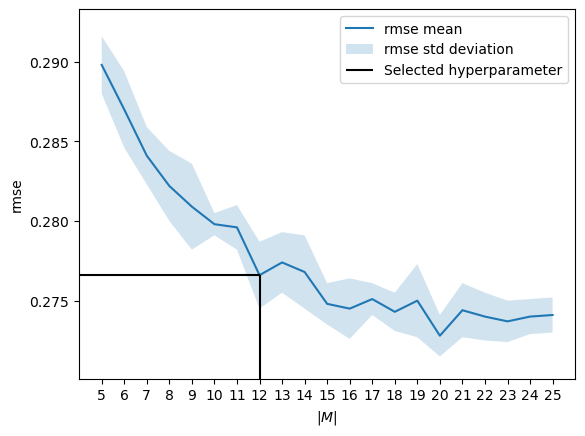

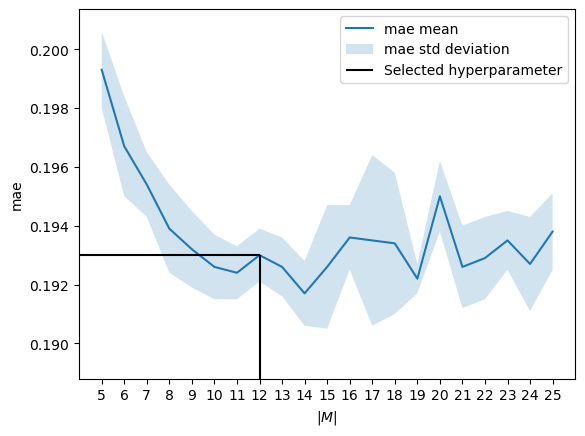

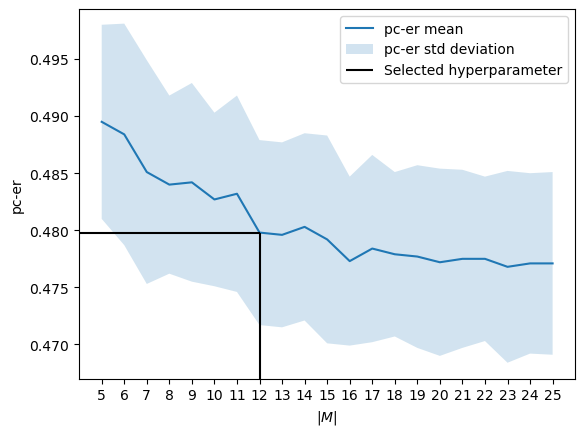

In [84]:
plot_evolution('rmse',df[df['d_in']==6])
plot_evolution('mae',df[df['d_in']==6])
plot_evolution('pc-er',df[df['d_in']==6])

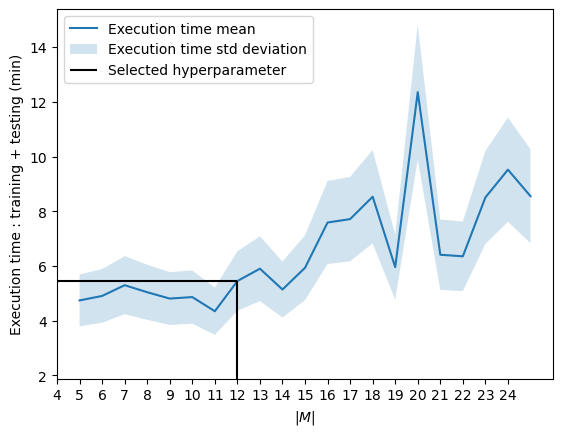

In [82]:
def plot_evolution_time(metric,df) :

    df = df.sort_values('num_responses')
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg']/60)
    std = np.array(df[metric + '_std']/60)

    # Plot mean +/- std
    ax.plot(x, y, label='Execution time mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label='Execution time std deviation')


    ax.set_ylabel("Execution time : training + testing (min)")
    ax.set_xlabel(r'$|M|$')
    ax.set_xticks(np.arange(4,25))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=4)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()/60-df[metric + '_std'].max()/60)

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=12,
        ymin=df[metric + '_avg'].min()/60-df[metric + '_std'].max()/60,       # start from y=0
        ymax=df[df['num_responses']==12][metric + '_avg']/60,
        color='black',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['num_responses']==12][metric + '_avg']/60,
        xmin=4,
        xmax=12,
        color='black',
        label = 'Selected hyperparameter'
    )


    ax.legend()
    plt.savefig("../../figs/"+str(metric) + "_portrait_hyperparam.pdf")

plot_evolution_time('exec_time',df[df['d_in']==6].drop_duplicates('num_responses'))

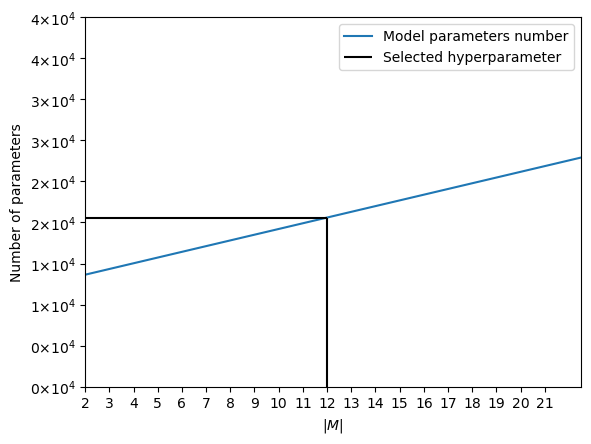

In [17]:
fig, ax = plt.subplots(1, 1)
plt.rcdefaults()
ax.plot(np.arange(2, 25), Y, label='Model parameters number')
ax.set_xlabel(r'$|M|$')
ax.set_ylabel("Number of parameters")
ax.set_xticks(np.arange(2, 22))

def tick_formatter(x, pos):
    return f'{int(x/1e4)}$\\times10^4$'

ax.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
ax.set_xlim(left=2, right=22.5)
ax.set_ylim(bottom=0, top=45000)

ax.vlines(
    x=12,
    ymin=0,
    ymax=nb_params(6, 12),
    color='black',
)

ax.hlines(
    y=nb_params(6, 12),
    xmin=0,
    xmax=12,
    color='black',
    label='Selected hyperparameter'
)

# Disable the background grid
ax.grid(False)

#ax.patch.set_alpha(0)

ax.legend()
plt.savefig("../../figs/param_nb_portrait_hyperparam.pdf")


In [48]:
nb_param_mat = np.zeros_like(mat_dic["exec_time"])
cond_mask = np.zeros_like(mat_dic["exec_time"])

def nb_params(d_r:int, M:int) :
    dim_n = 9
    user_n = 1152
    quest_n=116
    return d_r*dim_n*dim_n + (M+2)*d_r*quest_n+user_n*dim_n

def nb_params2(d_r:int, M:int) :
    dim_n = 9
    user_n = 1152
    quest_n=116
    return (M+2)*d_r*quest_n+user_n*dim_n

dim_n = 9
user_n = 1152
quest_n=116

for i in range(nb_param_mat.shape[0]) :
    for j in range(nb_param_mat.shape[1]):
        nb_param_mat[nb_param_mat.shape[0]-1-i,j] = nb_params(u_d_in[i], u_n_r[j])
        if u_d_in[i] >= (u_n_r[j]+2)*dim_n*quest_n/(dim_n*dim_n+(u_n_r[j]+2)*quest_n) :
            cond_mask[nb_param_mat.shape[0]-1-i,j] = 1

NameError: name 'mat_dic' is not defined

In [357]:
(nb_params(6, 12) - nb_params2(9, 12))/nb_params2(9, 12)

-0.17555235350624399

In [365]:
(0.44-0.405)/0.405

0.08641975308641969

In [366]:
(0.494-0.478)/0.478

0.03347280334728037

In [249]:
import pandas as pd

df = pd.read_csv("./data/movielens_hyperparam_study.csv", header=0, sep=",").astype(float)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(metric,df) :

    df = df.sort_values('d_in')

    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    ax.plot(x, y, label=str(metric)+' mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label=str(metric)+' std deviation')


    ax.set_ylabel(metric)
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()), top = np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg'],
        color='black',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg'],
        xmin=0,
        xmax=10,
        color='black',
        label = 'Selected hyperparameter'
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),
        color='red',
        label = f'Users\' embedding dim $|C|$'
    )

    ax.legend()
    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

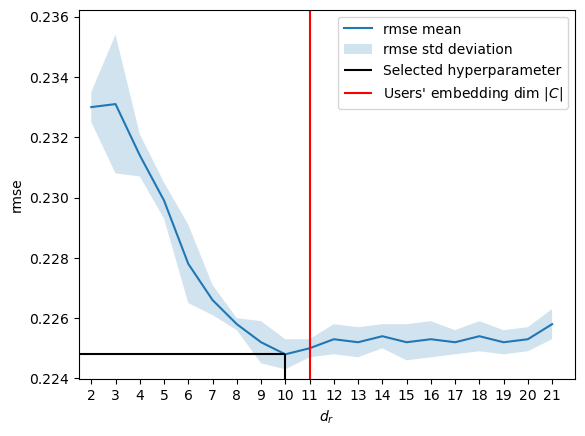

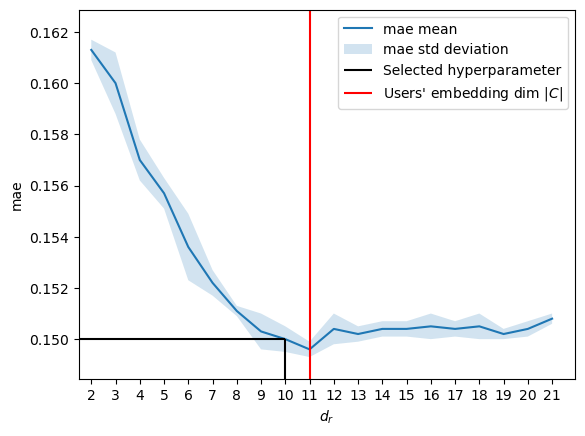

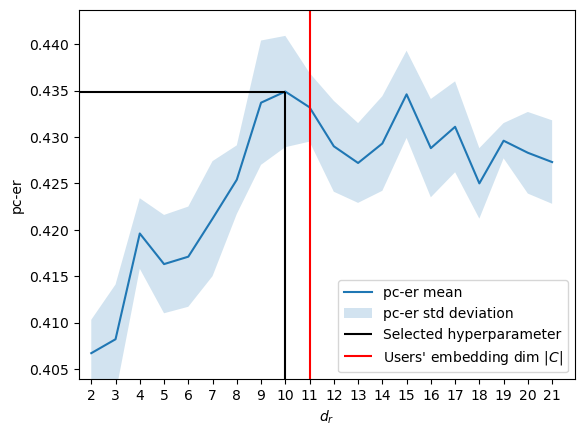

In [350]:
plot_evolution('rmse',df)
plot_evolution('mae',df)
plot_evolution('pc-er',df)

In [321]:
df

,d_in,exec_time_std,exec_time_avg,rmse_avg,rmse_std,mae_avg,mae_std,r2_avg,r2_std,pc-er_avg,pc-er_std,doa_avg,doa_std,rm_avg,rm_std
0,21.0,126.438237,755.007081,0.2258,0.0005,0.1508,0.0002,0.3485,0.0019,0.4273,0.0045,0.6880,0.0016,0.5103,0.0023
1,13.0,168.996420,801.572504,0.2252,0.0005,0.1502,0.0003,0.3519,0.0028,0.4272,0.0043,0.6872,0.0012,0.5089,0.0017
2,14.0,155.557740,758.024484,0.2254,0.0004,0.1504,0.0003,0.3505,0.0011,0.4293,0.0051,0.6881,0.0013,0.5127,0.0025
3,15.0,165.096678,764.697393,0.2252,0.0006,0.1504,0.0003,0.3518,0.0024,0.4346,0.0047,0.6881,0.0014,0.5158,0.0019
4,16.0,186.935613,748.597485,0.2253,0.0006,0.1505,0.0005,0.3512,0.0028,0.4288,0.0053,0.6880,0.0010,0.5101,0.0017
5,17.0,125.412773,763.423250,0.2252,0.0004,0.1504,0.0003,0.3517,0.0019,0.4311,0.0049,0.6881,0.0007,0.5124,0.0022
6,18.0,138.583167,734.125962,0.2254,0.0005,0.1505,0.0005,0.3505,0.0028,0.4250,0.0038,0.6883,0.0010,0.5075,0.0026
7,19.0,135.819423,832.564525,0.2252,0.0004,0.1502,0.0002,0.3517,0.0019,0.4296,0.0019,0.6869,0.0012,0.5099,0.0019
8,20.0,121.501415,780.701750,0.2253,0.0004,0.1504,0.0003,0.3512,0.0009,0.4283,0.0044,0.6861,0.0016,0.5102,0.0017
9,2.0,166.788587,1746.703555,0.2330,0.0005,0.1613,0.0004,0.3060,0.0032,0.4067,0.0036,0.6948,0.0013,0.5210,0.0016


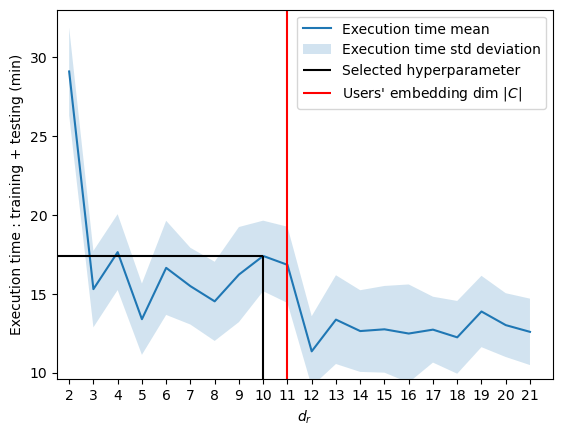

In [351]:
def plot_evolution_time(metric,df) :

    df = df.sort_values('d_in')
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg']/60)
    std = np.array(df[metric + '_std']/60)

    # Plot mean +/- std
    ax.plot(x, y, label='Execution time mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label='Execution time std deviation')


    ax.set_ylabel("Execution time : training + testing (min)")
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg']/60,
        color='black',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg']/60,
        xmin=0,
        xmax=10,
        color='black',
        label = 'Selected hyperparameter'
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),
        color='red',
        label = f'Users\' embedding dim $|C|$'
    )


    ax.legend()
    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

plot_evolution_time('exec_time',df)

In [ ]:
Y = [nb_params(x,5) for x in range(2,22)]

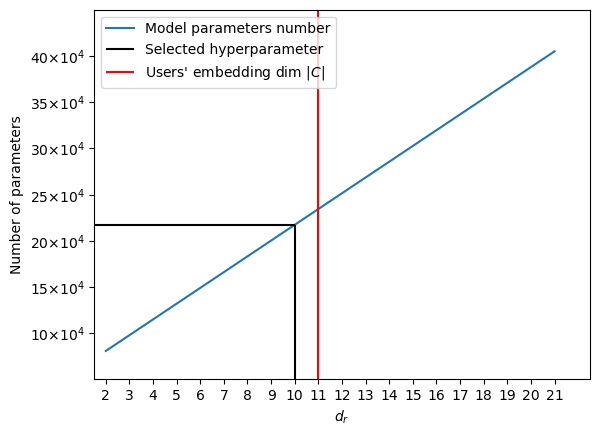

In [352]:

def nb_params(d_r:int, M:int) :
    dim_n = 11
    user_n = 4231
    quest_n=2421
    return d_r*dim_n*dim_n + (M+2)*d_r*quest_n+user_n*dim_n

from matplotlib.ticker import FuncFormatter

fig,ax = plt.subplots(1,1)
ax.plot(np.arange(2,22), Y, label='Model parameters number')
ax.set_xlabel(r'$d_r$')
ax.set_ylabel("Number of parameters")
ax.set_xticks(np.arange(2,22))
def tick_formatter(x, pos):
    # Here, x is the tick value.
    # Format as an integer multiplied by 10^4.
    return f'{int(x/1e4)}$\\times10^4$'

ax.yaxis.set_major_formatter(FuncFormatter(tick_formatter))

# Optionally, you can set the tick positions if needed:
# For instance, if you want ticks from 100000 to 400000 at intervals of 50000:
ax.set_yticks(range(100000, 400001, 50000))

# If you want the x-axis to start at 0
ax.set_xlim(left=1.5, right=22.5)
# If you want the y-axis to start at 0 so the vertical line can begin at y=0
ax.set_ylim(bottom=50000, top = 450000)

# Example vertical line from y=0 to y=0.234 at x=10
ax.vlines(
    x=10,
    ymin=50000,       # start from y=0
    ymax=nb_params(10,5),
    color='black',
)

# Example horizontal line from x=0 to x=10 at y=0.2248
ax.hlines(
    y=nb_params(10,5),
    xmin=0,
    xmax=10,
    color='black',
    label = 'Selected hyperparameter'
)

ax.vlines(
    x=11,
    ymin=5000,       # start from y=0
    ymax=500000,
    color='red',
    label = f'Users\' embedding dim $|C|$'
)

ax.legend()
plt.savefig("../../figs/param_nb_movielens_hyperparam.pdf")

In [355]:
def nb_params(d_r:int, M:int) :
    dim_n = 11
    user_n = 4231
    quest_n=2421
    return d_r*dim_n*dim_n + (M+2)*d_r*quest_n+user_n*dim_n

def nb_params2(d_r:int, M:int) :
    dim_n = 11
    user_n = 4231
    quest_n=2421
    return (M+2)*d_r*quest_n+user_n*dim_n

(nb_params(10,5)  - nb_params2(11,5))/nb_params2(11,5)

-0.0675529494587007

In [328]:
import matplotlib.pyplot as plt

# Example values (adjust as needed)

